# Biscuit Manufacturing

## Utils imports

In [63]:
from Utils import CSPRequirements as cspr
from Utils import dataImport as di
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First experiment : "Brutforce"-like backtrack

In this first test, we're trying all possible combinations using backtracking. This technique takes a gigantic amount of steps to iterate through all possible roll that respect the intial constraints:

- No overlap
- Total biscuit length <= roll length
- Biscuit placements respect the defects thresholds

Technically it can work, to prove so, we'll imagine our roll is only 50 units long, to prove that we get an optimized result. Limiting to 50 lowers the computation time to something feasble. 

After proving this basic technique works, we'll try to implements heursitics and other conditions to limit the exploration and amount of steps to find a solution.

In [92]:
roll_length = 50

# Biscuit thresholds
biscuit_thresholds = {
    0: {'size': 4, 'a': 4, 'b': 2, 'c': 3, 'value': 3},
    1: {'size': 8, 'a': 5, 'b': 4, 'c': 4, 'value': 12},
    2: {'size': 2, 'a': 1, 'b': 2, 'c': 1, 'value': 1},
    3: {'size': 5, 'a': 2, 'b': 3, 'c': 2, 'value': 8}
}

# Initialize roll and defect data
roll = di.build_roll(di.importDefects("defects.csv"), roll_length)
problem = cspr.BiscuitProblem(name="BiscuitOptimization", rollLength=roll_length, defect_data=roll, biscuit_thresholds=biscuit_thresholds)

print("Length of the roll: ", len(problem.roll))
problem.backtrack()

Length of the roll:  50


We can extract the best value for our roll (that respects all the constraints) and the corresponding roll

In [113]:
bestValue1 = problem.bestValue
bestRoll1 = problem.bestRoll
stepsTaken1 = problem.step

print(problem.bestValue)
print(problem.bestRoll)

76
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]


### Plot

To have a better idea of what our backtracking algorithm did, let's see how the best value evolved:

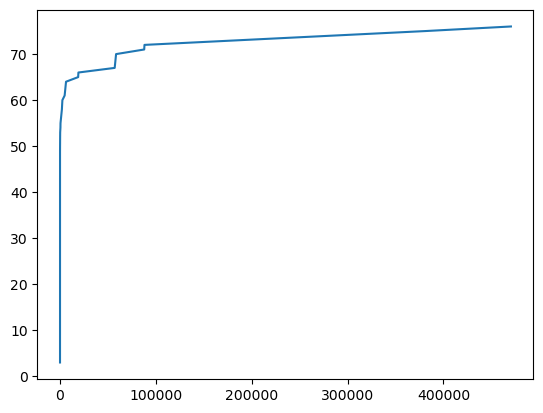

In [94]:
bestValues = []
bestValuesRank = []

for x in problem.bestValues:
    bestValues.append(x[0])
    bestValuesRank.append(x[1])

plt.plot(bestValuesRank, bestValues)

## Improving the solution : Parallelization

This is great ! Our algorithm works. But not optimized enough to give us solutions for greater roll length values in our lifespan. Let's try and optimize this.

Parallelizing tasks can help reduce global complexity. For instance: there are 2,656,615,626 combinations (with repetition) of 500 elements among 5 items (here, our biscuits (0,1,2,3) and "None". Note: this doesn't take into acount our constraints).

If we split the 500 items list into two 250 items list, we have 2 lists of 169,362,501 possible combinations. Thus a total of 338,725,002 states to explore.

if we further split our "main list", in for instance, 10 sub-lists (bins) of 50 elements. There are only 316,251 combinations of 5 elements among 50 items. Thus, a total of 3,162,510 states to explore. 

This technique would give us 10 optimized lists. We can suppose that the combination of these optimized sub-lists can yield a fair approximation of the best result in a more than reasonable amount of time.

### Python implementation


In [ ]:
def parallel_solver(roll_length, n_split):
    roll = di.build_roll(di.importDefects("defects.csv"), roll_length)
    sub_rolls = di.split_roll(roll, n_split)

    bestValues = []
    bestRolls = []
    stepsTakenList = []

    for i in range(n_split):
        print("Processing sub_roll : ", i)
        problem = cspr.BiscuitProblem(name="BiscuitOptimization", rollLength=len(sub_rolls[i]), defect_data=sub_rolls[i], biscuit_thresholds=biscuit_thresholds)
        problem.backtrack()
        bestValues.append(problem.bestValue)
        bestRolls.append(problem.bestRoll)
        stepsTakenList.append(problem.step)

    
    bestRoll = di.build_back_roll(bestRolls)

    bestValue = 0
    for value in bestValues:
        bestValue += value

    stepsTaken = 0
    for value in stepsTakenList:
        stepsTaken += value

    print("Finished parallel solve")
    return bestValue, bestRoll, stepsTaken

### Comparing results to the previous solve

In [114]:
bestValue2, bestRoll2, stepsTaken2 = parallel_solver(50, 2)

Processing sub_roll :  0
Processing sub_roll :  1
Finished parallel solve


In [115]:
print("No parallel Stats :\n- Roll value: ", bestValue1, "\n- Steps taken: ", stepsTaken1, "\n\nParallel solve stats :\n- Roll value: ", bestValue2, "\n- Steps taken: ", stepsTaken2)

No parallel Stats :
- Roll value:  76 
- Steps taken:  1886598 

Parallel solve stats :
- Roll value:  73 
- Steps taken:  992


For a value **4% off** the best value, we saved **1901% of the computation time.**

### Getting a first approximation for the 500 units long roll

In [122]:
bestValue3, bestRoll3, stepsTaken3 = parallel_solver(500, 13)

Processing sub_roll :  0
Processing sub_roll :  1
Processing sub_roll :  2
Processing sub_roll :  3
Processing sub_roll :  4
Processing sub_roll :  5
Processing sub_roll :  6
Processing sub_roll :  7
Processing sub_roll :  8
Processing sub_roll :  9
Processing sub_roll :  10
Processing sub_roll :  11
Processing sub_roll :  12
Finished parallel solve


Splitting in 13 rolls gives a good in-between computation time / splits. (We want as few splits as possible to get as close as possible to the actual solution). 

In [123]:
print("Parallel 500 solve stats :\n- Roll value: ", bestValue3, "\n- Steps taken: ", stepsTaken3)

Parallel 500 solve stats :
- Roll value:  758 
- Steps taken:  1171889


We now have a base result approximation to compare other algorithms we'll implement !